### Library Imports

In [1]:
%%capture
%pip install matplotlib
%pip install -U bitsandbytes
%pip install -U transformers
%pip install -U accelerate
%pip install -U peft
%pip install -U trl
%pip install wandb
%pip install huggingface_hub
%pip install numpy
%pip install tqdm
%pip install pandas scikit-learn transformers sacremoses
%pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [2]:
import pandas as pd
from collections import defaultdict
import torch.backends
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, BitsAndBytesConfig
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random
import torch
import networkx as nx
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel, PeftConfig

### Loading the model

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16",
)

model = AutoModelForCausalLM.from_pretrained(
    "tunknowed/llama3-fine-tuned-model",
    device_map="auto",
    torch_dtype="float16",
    quantization_config=bnb_config, 
)

tokenizer = AutoTokenizer.from_pretrained("tunknowed/llama3-fine-tuned-model")
tokenizer.pad_token_id = tokenizer.eos_token_id

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/671M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

In [7]:
def generate_test_prompt(data_point):
    return f"""
            Does Argument 2 Attack or Support Argument 1? You cannot cannot provide any answer besides "Attack" or "Support". If you don't see any fit then simply strive to give the most accurate evaluation possible between "Attack" and "Support".
            Remember your answer must be only one of two words: "Attack" or "Support"
Argument 1: {data_point["Argument1"]}
Argument 2: {data_point["Argument2"]}
Relation: """.strip()

In [8]:
def predict(test, model, tokenizer):
    y_pred = []
    categories = ["Attack", "Support"]
    
    for i in tqdm(range(len(test))):
        prompt = test.iloc[i]["text"]
        pipe = pipeline(task="text-generation", 
                        model=model, 
                        tokenizer=tokenizer, 
                        max_new_tokens=2, 
                        temperature=0.1)
        
        result = pipe(prompt)
        answer = result[0]['generated_text'].split("Relation:")[-1].strip()
        
        for category in categories:
            if category.lower() in answer.lower():
                y_pred.append(category)
                break
        else:
            y_pred.append("none")   
    return y_pred

In [9]:
def get_metrics(y_true, y_pred, n):
    accuracy = accuracy_score(y_true,y_pred)
    print(f"Accuracy: {accuracy}")
    print(classification_report(y_true,y_pred))
    ConfusionMatrixDisplay.from_predictions(y_true,y_pred)
    plt.title(f'Fine Tuned Model on N={n} - acc {accuracy:.3f}', size=15)
    plt.show()

### Testing

#### N=2

In [10]:
indirect_df = pd.read_csv("/kaggle/input/generated-relations/indirect_n2.csv")
labels = indirect_df.loc[:,"Relation"]
indirect_df = pd.DataFrame(indirect_df.apply(generate_test_prompt, axis=1), columns=["text"])

100%|██████████| 500/500 [03:30<00:00,  2.37it/s]


Accuracy: 0.718
              precision    recall  f1-score   support

      Attack       0.89      0.70      0.78       363
     Support       0.49      0.77      0.60       137

    accuracy                           0.72       500
   macro avg       0.69      0.74      0.69       500
weighted avg       0.78      0.72      0.73       500



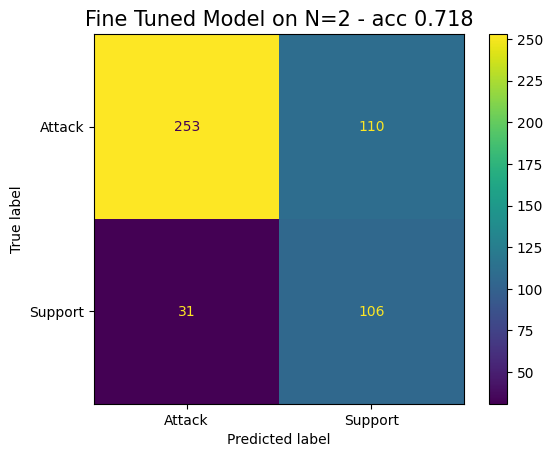

In [11]:
y_pred = predict(indirect_df, model, tokenizer)
get_metrics(labels, y_pred,2)

#### N=3

In [12]:
indirect_df = pd.read_csv("/kaggle/input/generated-relations/indirect_n3.csv")
labels = indirect_df.loc[:,"Relation"]
indirect_df = pd.DataFrame(indirect_df.apply(generate_test_prompt, axis=1), columns=["text"])

100%|██████████| 500/500 [03:29<00:00,  2.39it/s]


Accuracy: 0.604
              precision    recall  f1-score   support

      Attack       0.91      0.56      0.69       398
     Support       0.31      0.79      0.45       102

    accuracy                           0.60       500
   macro avg       0.61      0.67      0.57       500
weighted avg       0.79      0.60      0.64       500



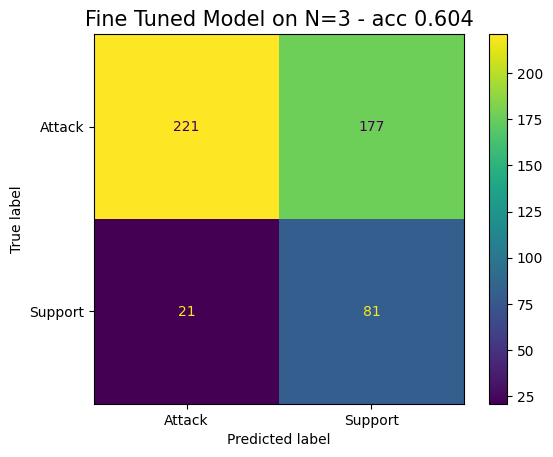

In [13]:
y_pred = predict(indirect_df, model, tokenizer)
get_metrics(labels, y_pred, 3)

#### N=5

In [14]:
indirect_df = pd.read_csv("/kaggle/input/generated-relations/indirect_n5.csv")
labels = indirect_df.loc[:,"Relation"]
indirect_df = pd.DataFrame(indirect_df.apply(generate_test_prompt, axis=1), columns=["text"])

100%|██████████| 500/500 [03:29<00:00,  2.38it/s]


Accuracy: 0.558
              precision    recall  f1-score   support

      Attack       0.89      0.53      0.66       411
     Support       0.24      0.71      0.36        89

    accuracy                           0.56       500
   macro avg       0.57      0.62      0.51       500
weighted avg       0.78      0.56      0.61       500



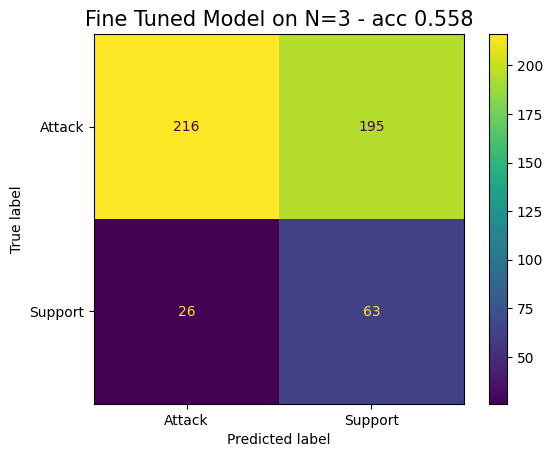

In [15]:
y_pred = predict(indirect_df, model, tokenizer)
get_metrics(labels, y_pred, 3)